# Markov Chain Monte Carlo

## Distance example

Say you have a distribution of sources with a strong prior and you observe them with some uncertainty. One example of this is the distribution of distances to stars. Assuming a constant density of stars, the underlying distribution should scale with $r^2$. This is our prior:

$$ P(r) \sim r^2 $$

This must be normalized. Obviously we cannot observe stars at an infinite distance, and doing so would cause the prior to diverge. We must impose, somewhat artificially, a maximum distance, $r_max$, to calculate the normalization constant. Our prior becomes:

$$ P(r) = 3 \frac{r^2}{r_{\rm max}^3} $$

### First, let's generate a sample from an exponential and add Gaussian noise

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Draw random distances using inverse sampling
N_stars=1000
dist_max = 1.0 # in kpc
dist = (np.random.uniform(size=N_stars))**(1.0/3.0) * dist_max

# Plot sample
bins = np.linspace(0.0, 1.0, 30)
plt.hist(dist, bins=bins, density=True, label='True Distance')

# Plot analytic
plt.plot(bins, 3.0 * bins**2 * dist_max**-3, linewidth=2.0, label='Analytic')

# Now add uncertainties of 100 pc
dist_obs = dist + np.random.normal(size=N_stars, scale=0.1)
# Array of errors
dist_err = 0.1 * np.ones(len(dist_obs))


bins = np.linspace(0.0, 1.3, 30)
plt.hist(dist_obs, bins=bins, density=True, histtype='step', 
         linewidth=2.0, color='k', label='Observed Distance')
plt.xlabel("Distance")
plt.ylabel("Probability Density")
plt.legend(loc="upper left")
plt.show()

<Figure size 640x480 with 1 Axes>

### Recovering $\alpha$ from observations
Let's imagine that we do not know the exponential in the power law, $\alpha$, and we want to solve for it. The correct answer is 2. Let's see if we can recover that.

We start with our probability notation. We want to determine $P(\alpha | \{ r \})$. We use our Bayesian formalism to split this into a prior and a likelihood:

$$ P(\alpha | \{ r \}) = \frac{1}{\mathcal{Z}} P(\{ r \} | \alpha) P(\alpha), $$

where $\mathcal{Z}$ is a normalization constant, which we have previously called the "evidence." 

Prior: $P(\alpha)$  
Likelihood: $P(\{ r \} | \alpha)$

#### What should the prior look like?

In this case the prior will have a minimal effect, but we would like to constrain it to positive values though. Our prior will be:
$$ P(\alpha) = \cases{0 : \alpha <= 0 \\ 1 : \alpha > 0} $$

NOTE: This prior is technically unnormalized and is therefore called an "improper prior." We could fix this by additionally setting a maximum value for $\alpha$ and setting the prior to $1/\alpha_{\rm max}$ for $0 < \alpha < \alpha_{\rm max}$. For simplicity, we will keep this prior unnormalized though.

#### What about the likelihood?

This is seemingly quite simple but can lead to much hand-wringing if you think about it too much. I will state it unproven here: the overal likelihood is the product of the likelihood of each data point, and the likelihood of each data point is the *normalized* probability density function evaluated at each data point:

$$ P(\{ r \} | \alpha) = \prod P(r | \alpha) $$
where
$$ P(r | \alpha) $$ is the likelihood of an observation.

##### Likelihood of an observed value

The likelihood of a true underlying distance, $r_{\rm true}$ is

$$ P(r_{\rm true} | \alpha) = (\alpha+1) \frac{r_{\rm true}^{\alpha}}{r_{\rm max}^{\alpha + 1}} $$

Let's define the difference between the observed distance ($r_{\rm obs}$) and the true, underlying distance ($r_{\rm true}$). First, we take our likelihood for an individual observation and marginalize over the underlying distance, $r_{\rm true}$:

$$ P( r | \alpha) = \int_{-\infty}^{\infty}  P(r_{\rm true}, r | \alpha) dr_{\rm true} $$
$$ P( r | \alpha) = \int_{0}^{r_{\rm max}}  P(r | r_{\rm true}) P(r_{\rm true} | \alpha) dr_{\rm true}$$

$P(r | r_{\rm true})$ is the Gaussian uncertainty on the observation. Remember that the power law is the distribution in $r_{\rm true}$ not $r_{\rm obs}$.

> Notice that the code will take a substantially longer time to run - this is due to the addition of only one integral within the minimzation routine. If you are marginalizing over two or three parameters (simultaneously dealing with two or three observational uncertainties) the problem can quickly become intractable.


#### Converting to the log of the posterior

For numerical simplicity, we use the (natural) log of the posterior, and therefore the log of the prior and the likelihood:

$$ \log P(\alpha | \{ r \}) = \log P(\alpha) + \log P(\{ r \} | \alpha) $$

### Now, some code

In [2]:
import scipy.stats as st

def func_pdf(alpha, x_max, x):
    P_x = (alpha + 1.0) * x ** alpha / x_max ** (alpha + 1.0)
    
    if type(x) is np.ndarray:
        P_x[x > x_max] = 0.0 
        P_x[x < 0.0] = 0.0
    elif x > x_max:
        return 0.0
    elif x < 0.0:
        return 0.0
    else:
        pass
        
    return P_x

def func_integrand(x, alpha, x_max, x_obs, x_err):
    return st.norm.pdf(x, loc=x_obs, scale=x_err) * func_pdf(alpha, x_max, x)

def ln_prior(alpha):
    return 0.0 if alpha >= 0.0 else -np.inf

def ln_likelihood(alpha, x_max, x_obs, x_err):
    
    ln_likelihood = 0.0
    for i in range(len(x_obs)):
        # Limits are either the limits of the pdf or 5 sigma from the observed value
        a = max(0.0, x_obs[i] - 5.0 * x_err[i])
        b = min(x_max, x_obs[i] + 5.0 * x_err[i])
        
        val = quad(func_integrand, a, b, args=(alpha, x_max, x_obs[i], x_err[i]), epsrel=1.0e-4, epsabs=1.0e-4)
        ln_likelihood += np.log(val[0])
    
    return ln_likelihood

def ln_posterior(alpha, x_max, x_obs, x_err):
    return ln_prior(alpha) + ln_likelihood(alpha, x_max, x_obs, x_err)

def neg_ln_posterior(alpha, x_max, x_obs, x_err):
    return -ln_posterior(alpha, x_max, x_obs, x_err)

187.75440944848674
124.41299265710605
72.3649380391705
29.414115933762098
-6.067911130168852
-35.321626688616085
-59.313368919683676
-78.8102960109107
-94.43138444362518
-106.6830579808503
-115.98476400863949
-122.68767404680138
-127.0886188196664
-129.4406466865991
-129.96114132729383
-128.8381453815021
-126.23534532608213
-122.2960436176297
-117.14635514427725
-110.8978027434327
-103.64944232872783
-95.4896161996636
-86.49740989550959
-76.74387066965534
-66.29303284645759
-55.202785611402575
-43.52561135262193
-31.309217032405048
-18.597076611902242
-5.4288991216624


'start = time.time()\nres = so.minimize(neg_ln_posterior, p0, args=(dist_max, dist_obs, dist_err))\nend = time.time()\n\nif res.success:\n    print("Expected result: 2.0")\n    print("Result:", res.x)\nelse:\n    print("Optimization failed")\n    \nprint("Elapsed time:", end-start, "seconds")\n\nplt.axvline(res.x)\n\nplt.xlabel(r"$\x07lpha$")\nplt.ylabel(r"$\\mathcal{L}$")\nplt.show()'

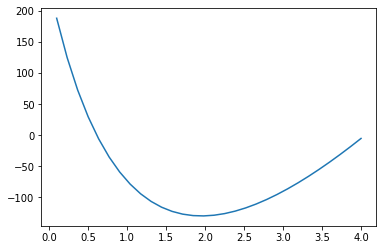

In [3]:
from scipy.optimize import minimize
from scipy.integrate import quad
import time

tmp_x = np.linspace(0.1, 4.0, 30)
tmp_y = np.zeros(len(tmp_x))
for i in range(len(tmp_x)):
    tmp_y[i] = neg_ln_posterior(tmp_x[i], dist_max, dist_obs, dist_err)
    print(tmp_y[i])
plt.plot(tmp_x, tmp_y)

# We will give it the wrong starting value
p0 = 4.0
dist_max = 1.0

print("Minimizing...")
start = time.time()
res = minimize(neg_ln_posterior, p0, args=(dist_max, dist_obs, dist_err))
end = time.time()

print()
if res.success:
    print("Expected result: 2.0")
    print("Result:", res.x)
else:
    print("Optimization failed")
    
print("Elapsed time:", end-start, "seconds")

plt.axvline(res.x)
plt.xlabel(r"$\alpha$")
plt.ylabel(r"$\mathcal{L}$")
plt.show()